<a href="https://colab.research.google.com/github/Lassethulstrup1/git_training/blob/main/Exam_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect drive

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).




# Import of dataset

Import of dataset

In [17]:
import requests
import zipfile
import os
# URL of the dataset
url = 'https://archive.ics.uci.edu/static/public/908/realwaste.zip'
# Path to save the downloaded ZIP file
zip_path = '/content/realwaste.zip'
# Download the ZIP file
print("Downloading the dataset...")
r = requests.get(url, allow_redirects=True)
with open(zip_path, 'wb') as zip_file:
 zip_file.write(r.content)
# Extract the ZIP file
print("Extracting the dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
 zip_ref.extractall('/content/')
# Clean up the ZIP file
os.remove(zip_path)

Extracting the dataset...


Check for images

In [18]:
from PIL import Image
import os
# Path to an image in your dataset (adjust the path as necessary)
image_path = '/content/realwaste-main/RealWaste/Cardboard/Cardboard_1.jpg'
# Load the image
image = Image.open(image_path)
# Print the size of the image
print(f"The image dimensions are: {image.size} (width x height)")
# If you also want to check the mode (e.g., RGB, RGBA, L (grayscale))
print(f"The image mode is: {image.mode}")

The image dimensions are: (524, 524) (width x height)
The image mode is: RGB


# Task 1 Inspect the images

Inspect the images for noise, ambiguous features, and rare features. Plot as many as you need
to familiarize yourself with the data. CH5 is helpful here.

Printing 5 pictures of each class

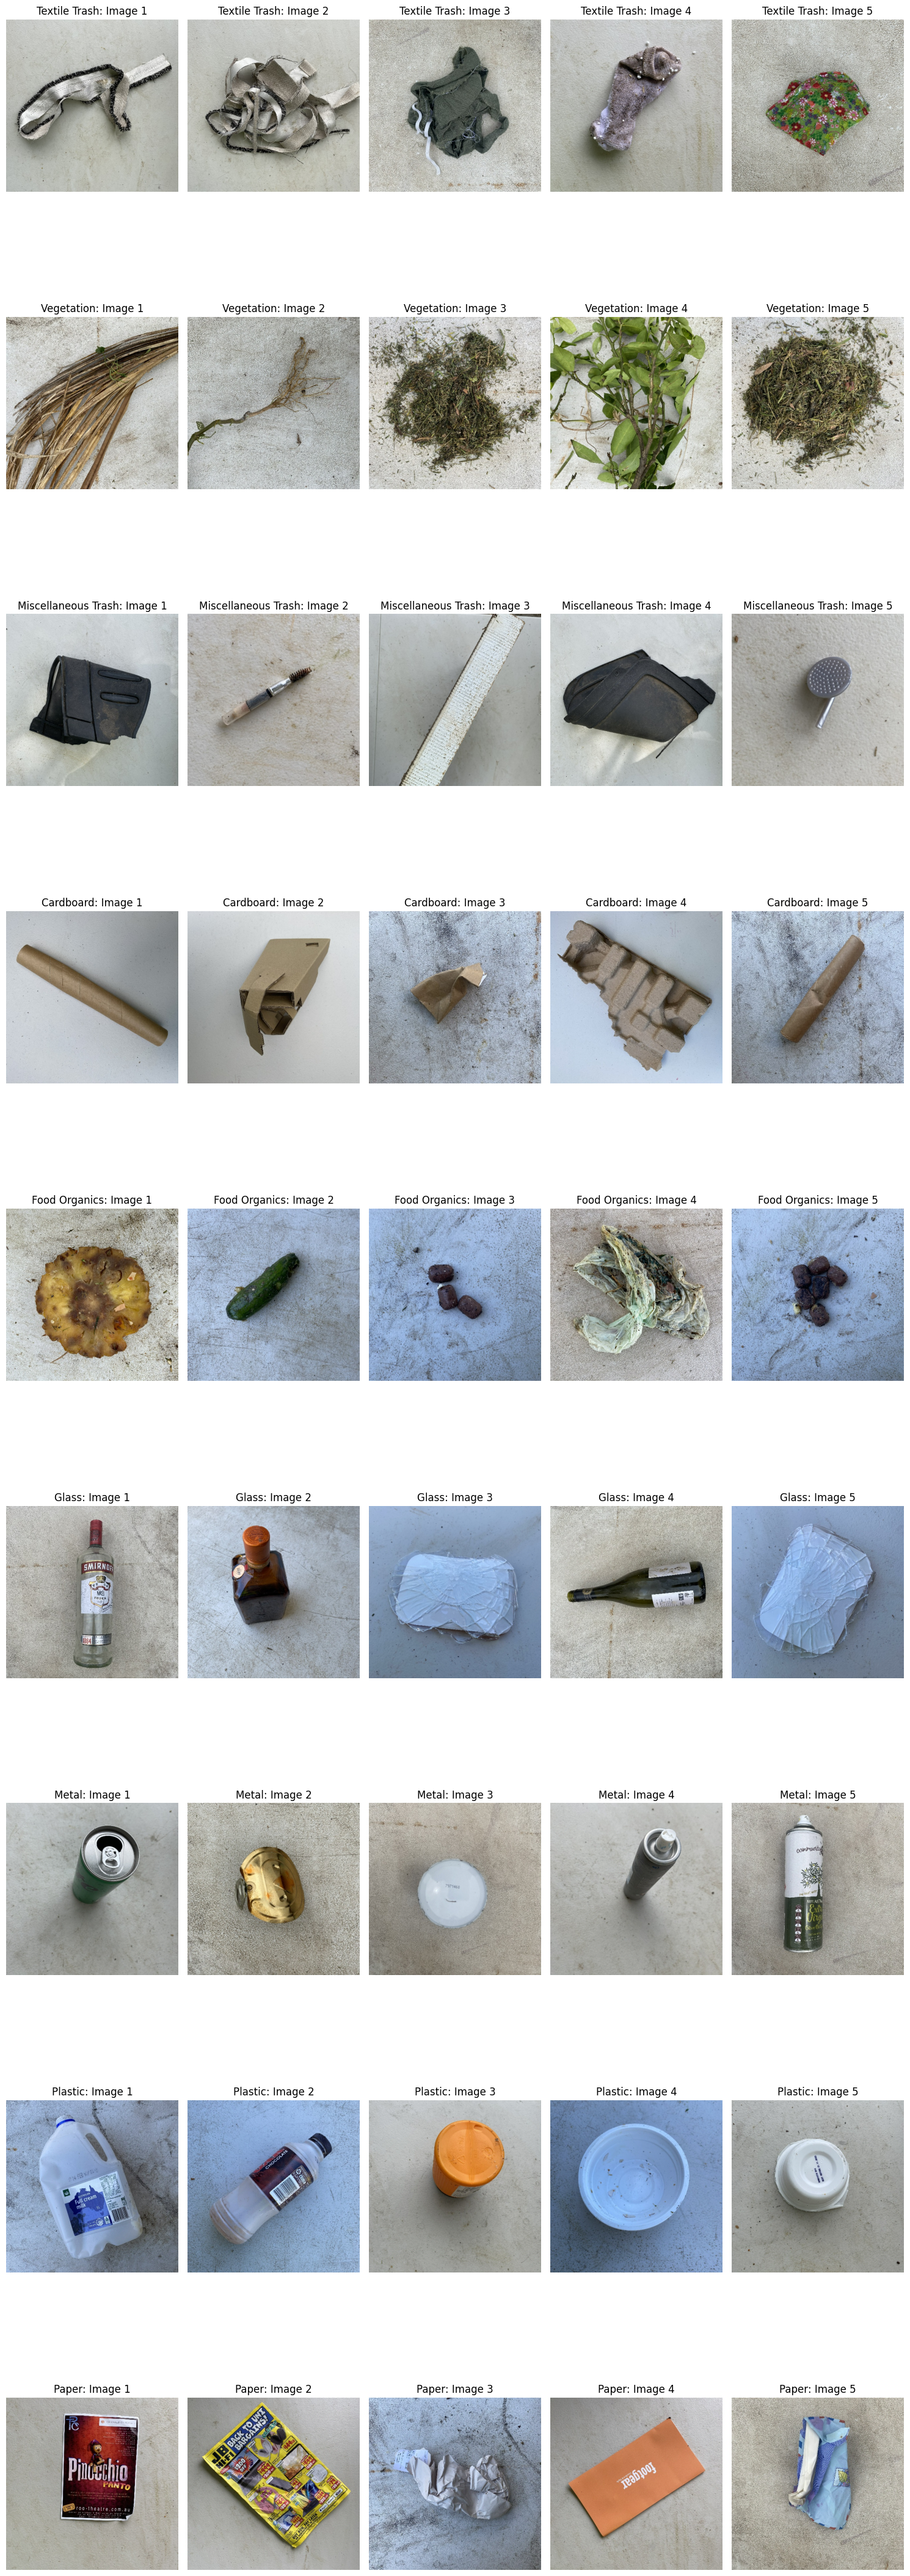

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image


# Path to your dataset directory (adjust as necessary)
dataset_path = '/content/realwaste-main/RealWaste'


# List all categories (folders) in the dataset directory
categories = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]


# Number of images to display per category
images_per_category = 5  # Showing 5 pictures


# Create a figure for plotting
# Adjust figsize accordingly to give enough space for all images
plt.figure(figsize=(15, len(categories) * images_per_category))


# Loop through each category and plot the specified number of images
for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    images_found = 0  # Counter to keep track of how many images have been plotted
    files = sorted(os.listdir(category_path))  # Sort files for consistent order


    for file in files:
        if file.lower().endswith('.jpg') and images_found < images_per_category:
            image_path = os.path.join(category_path, file)
            image = Image.open(image_path)
            plt.subplot(len(categories), images_per_category, i * images_per_category + images_found + 1)
            plt.imshow(image)
            plt.title(f"{category}: Image {images_found + 1}")
            plt.axis('off')
            images_found += 1


            if images_found == images_per_category:
                break  # Stop looking for more images if the limit is reached


# Show the plot
plt.tight_layout()
plt.show()


# Task 2 Read Single et al (2023)

Read the paper by Single er al. (2023). Focus on what you would need to know to replicate
their approach. For instance: Which models do they train? What’s the learning rate? Which
kind of data augmentation do they use? How well do their models perform?

# Task 3 Read CH6

Go through as many points on the universal workflow of machine learning in CH6 as you find
relevant (e.g., skip deployment, i.e., CH6.3). Use the same training/validation procedure and
split as in Single et al. (2023), but do not make a separate test set. A separate test set will be
provided at the exam.

# Task 4 Build and train a convnet

Build and train a convnet from scratch (CH 8.2 and 9.3). Save your best model such that you
can use it for inference on new images if given a new image at the exam. Also save the best
model’s training and validation plots. Keep detailed notes about why you build your model
the way you did. Compare your model’s performance to Single et al. (2023).

Data split

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Define the directory containing all images
base_dir = '/content/realwaste-main/RealWaste'


# Define the batch size and image size
batch_size = 32
img_height = 524
img_width = 524


# Create a training dataset
train_dataset = image_dataset_from_directory(
   directory=base_dir,
   validation_split=0.2,  # Specify the split ratio here
   subset="training",  # Specify this subset as training
   seed=123,  # Provide a seed for shuffling and reproducibility
   image_size=(img_height, img_width),
   batch_size=batch_size)


# Create a validation dataset
validation_dataset = image_dataset_from_directory(
   directory=base_dir,
   validation_split=0.2,  # Same split ratio as for the training set
   subset="validation",  # Specify this subset as validation
   seed=123,  # Same seed to ensure no overlap with training data
   image_size=(img_height, img_width),
   batch_size=batch_size)


# To see some output
print(f"Number of batches in train_dataset: {train_dataset.cardinality().numpy()}")
print(f"Number of batches in validation_dataset: {validation_dataset.cardinality().numpy()}")

Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.
Number of batches in train_dataset: 119
Number of batches in validation_dataset: 30


# Tunned model from slides

Building the model

In [4]:
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential(
   [
       layers.RandomFlip("horizontal_and_vertical"),  # Enables both horizontal and vertical flipping
       layers.RandomRotation(0.1),
       layers.RandomZoom(0.2),
   ]
)


inputs = keras.Input(shape=(524, 524, 3))
x = data_augmentation(inputs)


x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)


for size in [32, 64, 128, 256, 512]:
    residual = x


    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)


    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)


    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 524, 524, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 524, 524, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 524, 524, 3)          0         ['sequential[0][0]']          
                                                                                                  
 conv2d (Conv2D)             (None, 520, 520, 32)         2400      ['rescaling[0][0]']           
                                                                                              

Model compile

In [5]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="rmsprop",
             metrics=["accuracy"])


callbacks = [
   keras.callbacks.ModelCheckpoint(
       filepath="convnet_from_scratch_with_augmentation.keras",
       save_best_only=True,
       monitor="val_loss")
]
history = model.fit(
   train_dataset,
   epochs=10,
   validation_data=validation_dataset,
   callbacks=callbacks)

Epoch 1/10
119/119 [==============================] - 172s 1s/step - loss: 1.6457 - accuracy: 0.3951 - val_loss: 2.2598 - val_accuracy: 0.0663
Epoch 2/10
119/119 [==============================] - 141s 1s/step - loss: 1.4108 - accuracy: 0.4868 - val_loss: 2.3243 - val_accuracy: 0.2084
Epoch 3/10
119/119 [==============================] - 139s 1s/step - loss: 1.3208 - accuracy: 0.5208 - val_loss: 2.8314 - val_accuracy: 0.0663
Epoch 4/10
119/119 [==============================] - 140s 1s/step - loss: 1.2725 - accuracy: 0.5458 - val_loss: 2.0753 - val_accuracy: 0.2884
Epoch 5/10
119/119 [==============================] - 141s 1s/step - loss: 1.1929 - accuracy: 0.5694 - val_loss: 1.8343 - val_accuracy: 0.4147
Epoch 6/10
119/119 [==============================] - 139s 1s/step - loss: 1.1199 - accuracy: 0.6044 - val_loss: 2.1953 - val_accuracy: 0.3221
Epoch 7/10
119/119 [==============================] - 139s 1s/step - loss: 1.0659 - accuracy: 0.6213 - val_loss: 12.6785 - val_accuracy: 0.140

# Advanced model with 725961 params

---



Building the model

In [5]:
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential(
   [
       layers.RandomFlip("horizontal"),  # Enables horizontal flipping
       layers.RandomRotation(0.2),
       layers.RandomZoom(0.25),
   ]
)


inputs = keras.Input(shape=(524, 524, 3))
x = data_augmentation(inputs)


x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)


for size in [32, 64, 128, 256, 512]:
    residual = x


    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)


    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)


    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 524, 524, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 524, 524, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 524, 524, 3)          0         ['sequential[0][0]']          
                                                                                                  
 conv2d (Conv2D)             (None, 520, 520, 32)         2400      ['rescaling[0][0]']           
                                                                                              

In [6]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="rmsprop",
             metrics=["accuracy"])


callbacks = [
   keras.callbacks.ModelCheckpoint(
       filepath="/content/gdrive/MyDrive/ML2/convnet_epochs30.keras",
       save_best_only=True,
       monitor="val_loss")
]
history = model.fit(
   train_dataset,
   epochs=30,
   validation_data=validation_dataset,
   callbacks=callbacks)

Epoch 1/30
119/119 [==============================] - 187s 1s/step - loss: 1.6610 - accuracy: 0.3837 - val_loss: 2.3151 - val_accuracy: 0.0663
Epoch 2/30
119/119 [==============================] - 152s 1s/step - loss: 1.4177 - accuracy: 0.4847 - val_loss: 2.2941 - val_accuracy: 0.0758
Epoch 3/30
119/119 [==============================] - 151s 1s/step - loss: 1.3280 - accuracy: 0.5168 - val_loss: 2.7406 - val_accuracy: 0.0663
Epoch 4/30
119/119 [==============================] - 153s 1s/step - loss: 1.2585 - accuracy: 0.5539 - val_loss: 2.4648 - val_accuracy: 0.2189
Epoch 5/30
119/119 [==============================] - 151s 1s/step - loss: 1.1824 - accuracy: 0.5768 - val_loss: 1.8893 - val_accuracy: 0.3221
Epoch 6/30
119/119 [==============================] - 152s 1s/step - loss: 1.1031 - accuracy: 0.6060 - val_loss: 2.8791 - val_accuracy: 0.2705
Epoch 7/30
119/119 [==============================] - 150s 1s/step - loss: 1.0699 - accuracy: 0.6231 - val_loss: 2.9252 - val_accuracy: 0.3189

Plotting the loss/accrucacy plots

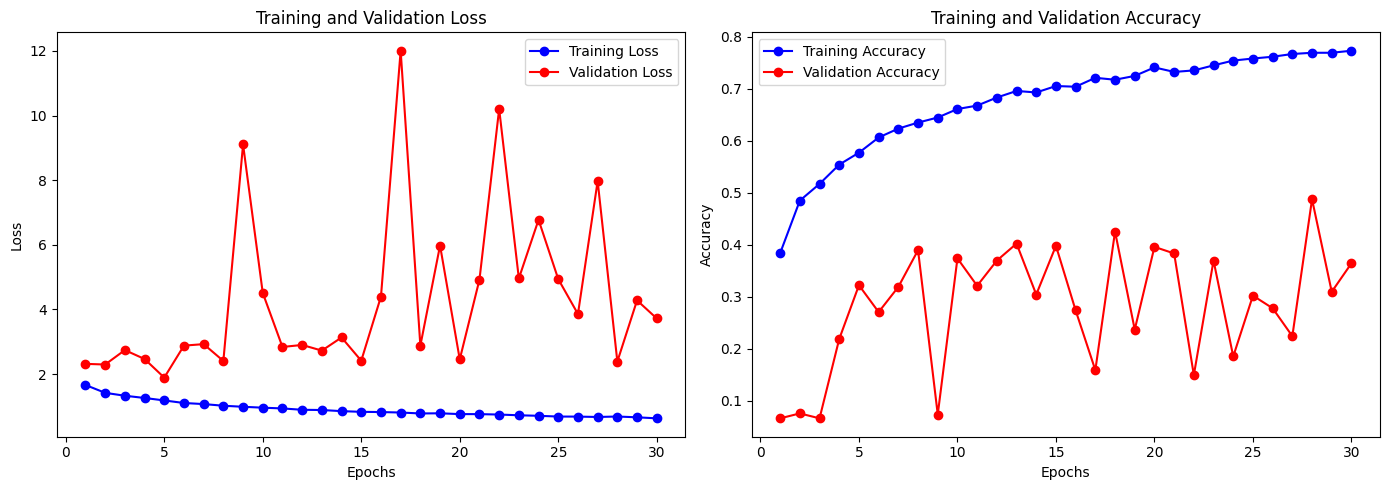

In [7]:
import matplotlib.pyplot as plt


# Assuming 'history' is the return value from model.fit()
history_dict = history.history

# Extracting loss and accuracy history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(14, 5))

# Training and validation loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjusts the plots to ensure they don't overlap
plt.show()

Calling the new model

In [8]:
new_model = tf.keras.models.load_model("/content/gdrive/MyDrive/ML2/convnet_epochs30.keras")

In [9]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 524, 524, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 524, 524, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 524, 524, 3)          0         ['sequential[0][0]']          
                                                                                                  
 conv2d (Conv2D)             (None, 520, 520, 32)         2400      ['rescaling[0][0]']           
                                                                                              

# Diamond hands model

Building the model

In [12]:
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"), #More agressive
        layers.RandomRotation(0.2), #More agressive
        layers.RandomZoom(0.3), #Even more agressive
    ]
)

inputs = keras.Input(shape=(524, 524, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)


x = layers.SeparableConv2D(filters=64, kernel_size=9, strides=2, activation=None, padding ='same')(x) #Larger kernel to see bigger patterns
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.AveragePooling2D(pool_size=2)(x) #only 2, to keep more information + avgpooling


x = layers.SeparableConv2D(filters=128, kernel_size=6, strides=2,activation=None, padding ='same')(x) #Larger kernel to see bigger patterns
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.AveragePooling2D(pool_size=2)(x) #only 2, to keep more information + avgpooling


x = layers.SeparableConv2D(filters=256, kernel_size=2, activation=None, padding ='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=3)(x)


x = layers.SeparableConv2D(filters=512, kernel_size=2, activation=None, padding ='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=3)(x)


x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(9, activation="softmax")(x)


# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


# Print the model summary to check the architecture
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 524, 524, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 524, 524, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 524, 524, 3)       0         
                                                                 
 separable_conv2d_10 (Separ  (None, 262, 262, 64)      499       
 ableConv2D)                                                     
                                                                 
 batch_normalization_10 (Ba  (None, 262, 262, 64)      256       
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 262, 262, 64)      0   

Model compile

In [13]:
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=optimizer,
             metrics=["accuracy"])


callbacks = [
   keras.callbacks.ModelCheckpoint(
       filepath="/content/gdrive/MyDrive/ML2/diamond_hands.keras",
       save_best_only=True,
       monitor="val_loss")
]
history = model.fit(
   train_dataset,
   epochs=100,
   validation_data=validation_dataset,
   callbacks=callbacks)

Epoch 1/100
119/119 [==============================] - 35s 255ms/step - loss: 1.7604 - accuracy: 0.4014 - val_loss: 2.1947 - val_accuracy: 0.0663
Epoch 2/100
119/119 [==============================] - 30s 242ms/step - loss: 1.4522 - accuracy: 0.5047 - val_loss: 2.2186 - val_accuracy: 0.0663
Epoch 3/100
119/119 [==============================] - 29s 242ms/step - loss: 1.3431 - accuracy: 0.5400 - val_loss: 2.3427 - val_accuracy: 0.0663
Epoch 4/100
119/119 [==============================] - 30s 245ms/step - loss: 1.2788 - accuracy: 0.5576 - val_loss: 2.6788 - val_accuracy: 0.0663
Epoch 5/100
119/119 [==============================] - 29s 239ms/step - loss: 1.2371 - accuracy: 0.5755 - val_loss: 2.5173 - val_accuracy: 0.0695
Epoch 6/100
119/119 [==============================] - 29s 241ms/step - loss: 1.1928 - accuracy: 0.5876 - val_loss: 1.6203 - val_accuracy: 0.3716
Epoch 7/100
119/119 [==============================] - 30s 243ms/step - loss: 1.1691 - accuracy: 0.5865 - val_loss: 1.3551 -

Plotting the loss/accrucacy plots

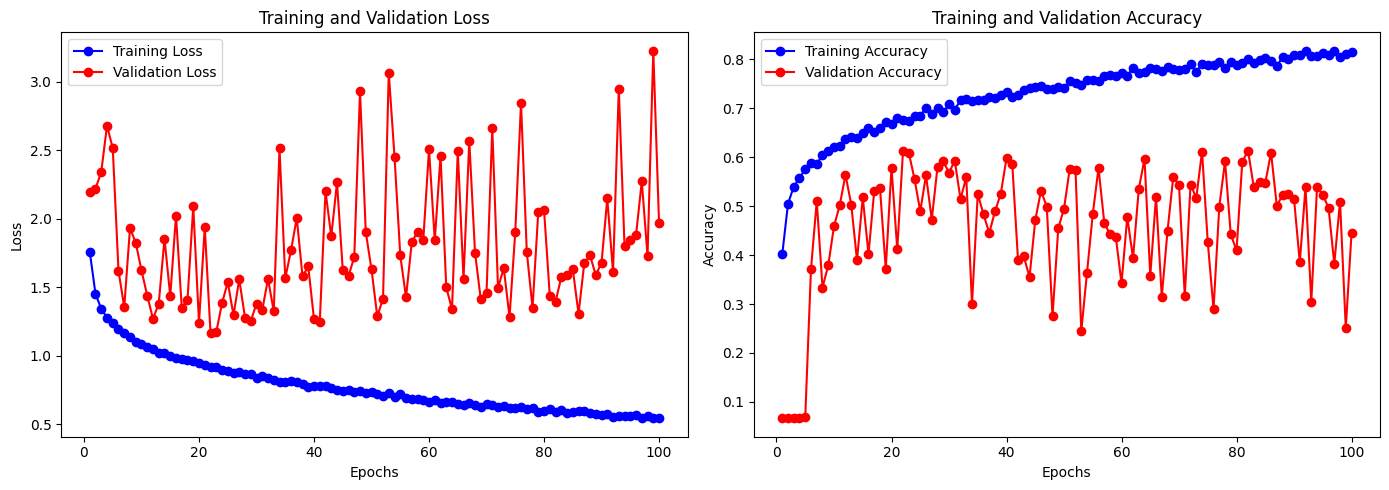

In [14]:
import matplotlib.pyplot as plt


# Assuming 'history' is the return value from model.fit()
history_dict = history.history

# Extracting loss and accuracy history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(14, 5))

# Training and validation loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjusts the plots to ensure they don't overlap
plt.show()

Calling the model

In [15]:
new_model = tf.keras.models.load_model("/content/gdrive/MyDrive/ML2/diamond_hands.keras")

In [16]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 524, 524, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 524, 524, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 524, 524, 3)       0         
                                                                 
 separable_conv2d_10 (Separ  (None, 262, 262, 64)      499       
 ableConv2D)                                                     
                                                                 
 batch_normalization_10 (Ba  (None, 262, 262, 64)      256       
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 262, 262, 64)      0   

# Task 5 Build and train a pretrained model

Build and train a pretrained model (CH 8.3). Select one of the pretrained models used by
Single et al. (2023). Save your best model such that you can use it for inference on new
images if given a new image at the exam. Also save the best model’s training and validation plots. Keep detailed notes about why you build your model the way you did. Compare your
model’s performance to Single et al. (2023).

Instantiating the InceptionV3 convolutional base

In [50]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

conv_base = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)
conv_base.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


Model summary

In [51]:
 conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 90, 90, 32)           864       ['input_23[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 90, 90, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 90, 90, 32)           0         ['bn_Conv1[

Print weigths

In [52]:
>>> conv_base.trainable = True
>>> print("This is the number of trainable weights "
 "before freezing the conv base:", len(conv_base.trainable_weights))
#This is the number of trainable weights before freezing the conv base: 26
>>> conv_base.trainable = False
>>> print("This is the number of trainable weights "
 "after freezing the conv base:", len(conv_base.trainable_weights))
#This is the number of trainable weights after freezing the conv base: 0

This is the number of trainable weights before freezing the conv base: 156
This is the number of trainable weights after freezing the conv base: 0


 Adding a data augmentation stage and a classifier to the convolutional base

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load the MobileNetV2 model
conv_base = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

# Freeze some layers to reduce training time and avoid overfitting
for layer in conv_base.layers:
    layer.trainable = False

# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.3),
    ]
)

# Input layer
inputs = keras.Input(shape=(524, 524, 3))
x = data_augmentation(inputs)
x = layers.Resizing(180, 180)(x)
x = preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(24, activation='relu')(x)
outputs = layers.Dense(9, activation="softmax")(x)

# Model
pre_trained_model = keras.Model(inputs, outputs)

pre_trained_model.summary()


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 524, 524, 3)]     0         
                                                                 
 sequential_16 (Sequential)  (None, 524, 524, 3)       0         
                                                                 
 resizing_8 (Resizing)       (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_14 (TFOpLa  (None, 180, 180, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_14 (TFOpL  (None, 180, 180, 3)       0         
 ambda)                                                          
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 6, 6, 1280)        225

Compile the model

In [ ]:
pre_trained_model.compile(loss="sparse_categorical_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])


callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath=("/content/gdrive/MyDrive/ML2/pre_trained_model1.keras"),
 save_best_only=True,
 monitor="val_loss")
]

history = pre_trained_model.fit(
   train_dataset,
   epochs=50,
   validation_data=validation_dataset,
   callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 363s 3s/step - loss: 1.7494 - accuracy: 0.3911 - val_loss: 1.0656 - val_accuracy: 0.6379
Epoch 2/50
119/119 [==============================] - 380s 3s/step - loss: 1.1550 - accuracy: 0.6120 - val_loss: 0.8506 - val_accuracy: 0.6884
Epoch 3/50
119/119 [==============================] - 352s 3s/step - loss: 1.0000 - accuracy: 0.6531 - val_loss: 0.8075 - val_accuracy: 0.7011
Epoch 4/50
119/119 [==============================] - 346s 3s/step - loss: 0.8978 - accuracy: 0.6920 - val_loss: 0.7346 - val_accuracy: 0.7358
Epoch 5/50
119/119 [==============================] - 366s 3s/step - loss: 0.8746 - accuracy: 0.6991 - val_loss: 0.7149 - val_accuracy: 0.7316
Epoch 6/50
 13/119 [==>...........................] - ETA: 4:43 - loss: 0.7768 - accuracy: 0.7019